## [Practical PyTorch: Classifying Names with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb)
We will be building and training a basic character-level RNN to classify words. A character-level RNN reads words as a series of characters - outputting a prediction and "hidden state" at each step, feeding its previous hidden state into each next step. We take the final prediction to be the output, i.e. which class the word belongs to.
Specifically, we'll train on a few thousand surnames from 18 languages of origin, and predict which language a name is from based on the spelling:
```shell
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```

## Preparing the Data
Included in the data/names directory are 18 text files named as "[Language].txt". Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).
We'll end up with a dictionary of lists of names per language, {language: [names ...]}. The generic variables "category" and "line" (for language and name in our case) are used for later extensibility.

In [1]:
import glob

all_filenames = glob.glob('../data/names/*.txt')
print(all_filenames)

['../data/names/Czech.txt', '../data/names/German.txt', '../data/names/Arabic.txt', '../data/names/Japanese.txt', '../data/names/Chinese.txt', '../data/names/Vietnamese.txt', '../data/names/Russian.txt', '../data/names/French.txt', '../data/names/Irish.txt', '../data/names/English.txt', '../data/names/Spanish.txt', '../data/names/Greek.txt', '../data/names/Italian.txt', '../data/names/Portuguese.txt', '../data/names/Scottish.txt', '../data/names/Dutch.txt', '../data/names/Korean.txt', '../data/names/Polish.txt']


In [2]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii('Ślusàrski'))

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
Slusarski


In [3]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in all_filenames:
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print('n_categories =', n_categories)
print(all_categories)

n_categories = 18
['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']


In [4]:
print(category_lines['Chinese'][-5:])

['Zhai', 'Zhang', 'Zhi', 'Zhuan', 'Zhui']


## Turning Names into Tensors
Now that we have all the names organized, we need to turn them into Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size < 1 x n\_letters >. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = < 0 1 0 0 0 ...>.

To make a word we join a bunch of those into a 2D matrix < line_length x 1 x n_letters >.

That extra 1 dimension is because PyTorch assumes everything is in batches - we're just using a batch size of 1 here.

In [5]:
import torch

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    letter_index = all_letters.find(letter)
    tensor[0][letter_index] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

In [6]:
print(letter_to_tensor('J'))
print(line_to_tensor('Jones').size())



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     1     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 56 
    0     0     0     0     0
[torch.FloatTensor of size 1x57]

torch.Size([5, 1, 57])


## Creating the Network
Before autograd, creating a recurrent neural network in Torch involved cloning the parameters of a layer over several timesteps. The layers held hidden state and gradients which are now entirely handled by the graph itself. This means you can implement a RNN in a very "pure" way, as regular feed-forward layers.

This RNN module (mostly copied from the PyTorch for Torch users tutorial) is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output.
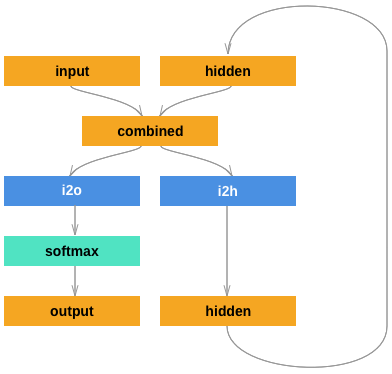

In [7]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))
    
class RNN2(nn.Module): # W[s_t-1, x_t] = s_t; Vs_t = o_t
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN2, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        # self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        # output = self.i2o(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

## Manually testing the network
To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We'll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

Remember that PyTorch modules operate on Variables rather than straight up Tensors.

For the sake of efficiency we don't want to be creating a new Tensor for every step, so we will use line_to_tensor instead of letter_to_tensor and use slices. This could be further optimized by pre-computing batches of Tensors.

As you can see the output is a < 1 x n_categories > Tensor, where every item is the likelihood of that category (higher is more likely).

In [8]:
n_hidden = 128
rnn = RNN2(n_letters, n_hidden, n_categories)

input = Variable(letter_to_tensor('A'))
hidden = rnn.init_hidden()

output, next_hidden = rnn(input, hidden)
print('input.size =', input.size()) # 1(batch_size)*inp_dim
print('output.size =', output.size()) # 1(batch_size)*n_cat

input = Variable(line_to_tensor('Albert'))
hidden = rnn.init_hidden()

output, next_hidden = rnn(input[0], hidden) # same
print(output) 

input.size = torch.Size([1, 57])
output.size = torch.Size([1, 18])
Variable containing:

Columns 0 to 9 
-2.8631 -2.8481 -2.8836 -2.9133 -3.0034 -2.8784 -3.0156 -2.9003 -2.9203 -2.8339

Columns 10 to 17 
-2.8457 -2.9258 -2.9986 -2.8495 -2.9215 -2.7641 -2.8640 -2.8338
[torch.FloatTensor of size 1x18]



## Preparing for Training
Before going into training we should make a few helper functions. The first is to interpret the output of the network, which we know to be a likelihood of each category. We can use Tensor.topk to get the index of the greatest value:

In [9]:
def category_from_output(output):
    top_value, top_index = output.data.topk(1) # Tensor out of Variable with .data
    category_index = top_index[0][0] # default dim = -1, top_index=batch_size*1
    return all_categories[category_index], category_index, torch.exp(top_value)[0][0] # likelihood

print(category_from_output(output))
print(torch.sum(torch.exp(output.data)))

('Dutch', 15, 0.06303220987319946)
1.0


In [10]:
import random

def random_training_pair():                                                                                                               
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_pair()
    print('category =', category, '/ line =', line)

category = Chinese / line = Luo
category = English / line = Delamarre
category = Czech / line = Rebka
category = Portuguese / line = Santiago
category = Chinese / line = Zhuan
category = French / line = Girard
category = Spanish / line = Martinez
category = Italian / line = Garfagnini
category = Japanese / line = Muraguchi
category = Chinese / line = Yang


## Training the Network
Now all it takes to train this network is show it a bunch of examples, have it make guesses, and tell it if it's wrong.

For the loss function nn.NLLLoss is appropriate, since the last layer of the RNN is nn.LogSoftmax.


We will also create an "optimizer" which updates the parameters of our model according to its gradients. We will use the vanilla SGD algorithm with a low learning rate.

Each loop of training will:
- Create input and target tensors
- Create a zeroed initial hidden state
- Read each letter in and
    - Keep hidden state for next letter
- Compare final output to target
- Back-propagate
- Return the output and loss

In [11]:
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

def train(category_tensor, line_tensor):
    # [torch.LongTensor of size 1]; [torch.FloatTensor of size seq_len x batch x n_letters]
    rnn.zero_grad() # or optimizer.zero_grad()
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i],hidden)
        
    loss = criterion(output, category_tensor) # (minibatch,C); (minibatch):index [0, C-1]
    loss.backward()
    
    optimizer.step()
    
    return output, loss.data[0]

Now we just have to run that with a bunch of examples. Since the train function returns both the output and loss we can print its guesses and also keep track of loss for plotting. Since there are 1000s of examples we print only every print_every time steps, and take an average of the loss.

In [12]:
import time
import math

n_steps = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for step in range(1, n_steps + 1):
    # Get a random training input and target
    category, line, category_tensor, line_tensor = random_training_pair()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    # Print epoch number, loss, name and guess
    if step % print_every == 0:
        guess, guess_i, prob = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('step: %d %d%% (%s) loss=%.4f %s / %s prob=%.3f %s' % (step, step / n_steps * 100, time_since(start), loss, line, guess, prob, correct))

    # Add current loss avg to list of losses
    if step % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

step: 5000 5% (0m 7s) loss=3.0393 Shamoun / German prob=0.079 ✗ (Arabic)
step: 10000 10% (0m 13s) loss=1.1722 Gan / Chinese prob=0.310 ✓
step: 15000 15% (0m 20s) loss=2.3459 Ha / Czech prob=0.153 ✗ (Korean)
step: 20000 20% (0m 27s) loss=2.3005 Keating / German prob=0.150 ✗ (English)
step: 25000 25% (0m 34s) loss=0.8422 Hao / Chinese prob=0.431 ✓
step: 30000 30% (0m 41s) loss=2.2357 Kim / Korean prob=0.477 ✗ (Vietnamese)
step: 35000 35% (0m 48s) loss=0.6276 Duong / Vietnamese prob=0.534 ✓
step: 40000 40% (0m 55s) loss=5.4910 Lebzak / Polish prob=0.609 ✗ (Russian)
step: 45000 45% (1m 2s) loss=0.3126 Bahar / Arabic prob=0.732 ✓
step: 50000 50% (1m 9s) loss=1.2081 Dahl / German prob=0.299 ✓
step: 55000 55% (1m 16s) loss=0.6311 Cleirich / Irish prob=0.532 ✓
step: 60000 60% (1m 23s) loss=3.9977 Shaw / Chinese prob=0.728 ✗ (Scottish)
step: 65000 65% (1m 30s) loss=0.1025 Tableriou / Greek prob=0.903 ✓
step: 70000 70% (1m 37s) loss=1.2418 Sha / Chinese prob=0.289 ✓
step: 75000 75% (1m 44s) loss

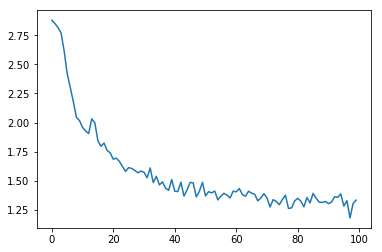

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

## Evaluating the Results
To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with evaluate(), which is the same as train() minus the backprop.

You can pick out bright spots off the main axis that show which languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish for Italian. It seems to do very well with Greek, and very poorly with English (perhaps because of overlap with other languages).

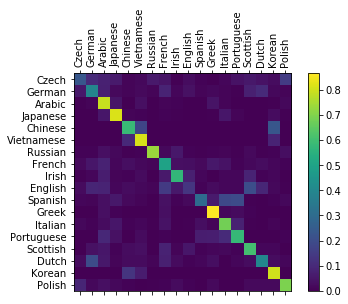

In [14]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair()
    output = evaluate(line_tensor)
    guess, guess_i, prob = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()


## Running on User Input

In [15]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(line_to_tensor(input_line)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = torch.exp(topv)[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(0.47) Russian
(0.28) Czech
(0.11) Polish

> Jackson
(0.91) Scottish
(0.04) English
(0.01) Russian

> Satoshi
(0.56) Arabic
(0.32) Japanese
(0.04) Polish
